I went to a talk a couple of weeks ago at Stanford on using machine learning to understand complex biological data. At one point in the talk the speaker made an offhand comment about data so simple "that a five year old could cluster it". Wow, were you that smart at five?

Anyway, I don't have kids, but I know enough about them that young children always ask, "*why?*" Maybe that five-year old mindset is instructive in machine learning. I think I've had a good intuitive grasp of Principcal Component Analysis (PCA) *as a black box*. That is, I know it is a way to reduce multidimensional datasets down to discover potentially interesting axes of variation.

But my eyes gloss over when I start hearing about reconstituting the data matrix, etc. So I want to take that position of the five year old, and ask "Why?" To do this, I want to understand the actual operations of PCA, rather than the pre-packaged R function.

FYI, [this](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) is excellent background reading.

First use a pre-loaded R dataset of crime incidence by state. First, let's see the data.

In [11]:
head(USArrests)
library(cluster)

Murder Assault UrbanPop Rape
Alabama      13.2     236       58 21.2
Alaska       10.0     263       48 44.5
Arizona       8.1     294       80 31.0
Arkansas      8.8     190       50 19.5
California    9.0     276       91 40.6
Colorado      7.9     204       78 38.7

## 1) The first step we need to take is to center the data.

"*Why?*"
If we don't, the highest variance in the data would just be driven by the distance to the origin.

An optional step is to scale the data, since if a particular variable has a higher magnitude, it will tend to dominate the variance captured by PCA. There is not a convention on whether scaling should always be done or not. Here, I'll skip it.

In [12]:
centerData = scale(USArrests,scale=F)
head(centerData)

Murder Assault UrbanPop   Rape
Alabama     5.412   65.24    -7.54 -0.032
Alaska      2.212   92.24   -17.54 23.268
Arizona     0.312  123.24    14.46  9.768
Arkansas    1.012   19.24   -15.54 -1.732
California  1.212  105.24    25.46 19.368
Colorado    0.112   33.24    12.46 17.468

## 2) Next up, calculate the covariance matrix.  

"*Why?*"  

Because covariance will tell us if two variables tend to increase or decrease together, summarized by a positive or negative sign. 
"*What is covariance*"
Well, consider the relationship between two variables, x and y. The covariance would be

$$(y_{mean} - y_{i}) * (x_{mean} - x_{i})$$

*What does that mean?*

Okay, let's think about some data we know that co-vary, thus they should have a positive covariance.

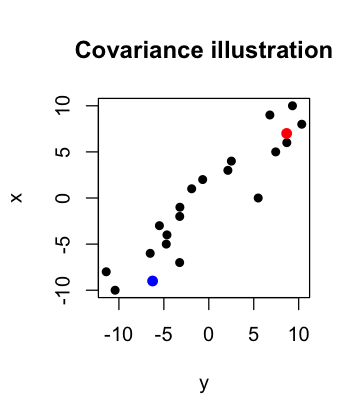

In [13]:
options(repr.plot.height=3.5 , repr.plot.width=3)
x = -10:10
y = x + rnorm(length(x),sd=3)
cols = rep('black',length(x)); cols[2]='blue'; cols[2]='blue'; cols[18]='red'
cexs=rep(1,length(x)); cexs[c(2,18)]=1.2;

plot(y,x,col=cols,cex=cexs,pch=16,main='Covariance illustration')

So, lets consider the two points, shown in red and blue. First, the red point. If you calculate $(y_{mean} - y_{i})$, you get a negative value. Similarly, $(x_{mean} - x_{i})$ is negative. So two negatives multiplied is positive. For the blue point, both $(x_{mean} - x_{i})$ and $(y_{mean} - y_{i})$ are positive and their product is also positive.

So, the covariance quantifies this relationship, which here we can see by eye. If the data are anticorrelated, then the covariance will be negative.

The covariance matrix quantifies every combination of variables. Thus if you have $n$ samples and $p$ variables, the covariance matrix will be a square $p * p$ matrix. 

Okay, let's compute it.

In [14]:
cvMat = cov(centerData)

 ## 3) Calculate the eigenvectors/eigenvalues of the covariance matrix.
 
The covariance matrix, because it is symmetric, will have _p_ eigenvectors associated with it. The first eigenvector, the first principal component, will describe the axis of greatest variance in the data.

_"Why?"_

Okay, you got me. The sum of the diagonals (the trace) is [the variance](http://stats.stackexchange.com/questions/102658/why-does-pca-maximize-total-variance-of-the-projection). Some [matrix algebra can prove](http://wwwpub.utdallas.edu/~herve/Abdi-EVD2007-pretty.pdf) that the eigenvectors are indeed maximizing variance, but that's more effort than I want to invest now. 

Anyway the second, third, etc., will capture the subsequent highest axes of variance. Additionally, each of the eigenvectors will, by definition be orthogonal. Thus, the data can be re-expressed in terms of the principal components.

Let's take a look.

In [15]:
eigData = eigen(cvMat)
eigVec = eigData$vectors
eigVal = eigData$values

cat('Here are the eigenvectors. The left-most column is the first eigenvector,\nwhich captures the greatest axis of variance in the data.\nEigenvectors 2-4 are sequentially right-ward columns. \n\n')
df = data.frame(eigVec); colnames(df)=c('eigVec-1','eigVec-2','eigVec-3','eigVec-4')
df

Here are the eigenvectors. The left-most column is the first eigenvector,
which captures the greatest axis of variance in the data.
Eigenvectors 2-4 are sequentially right-ward columns. 



eigVec-1    eigVec-2    eigVec-3    eigVec-4
1 -0.04170432  0.04482166  0.07989066  0.99492173
2 -0.99522128  0.05876003 -0.06756974 -0.03893830
3 -0.04633575 -0.97685748 -0.20054629  0.05816914
4 -0.07515550 -0.20071807  0.97408059 -0.07232502

## 4) Compute new data from feature vector
Now that we have the the eigenvectors, we will choose a feature vector, composed of of a combination of PCs. Let's choose the first two, which capture the top two axes of variation.

By multiplying the transposed eigenvectors and raw data, we can project the original data onto the principal components.

"_Why is this?_"

What actually happens during the matrix multiplication is essentially taking the dot product, which if you remember from calculus, is used to translate vectors to a new dimensional space. So, that explains how PCA actually is doing dimensionality reduction. Keeping the maximal variance using a subset of PCs can preferentially reduce the effects of redundancy and noise. 

In [16]:
# Define feature vector
featureVec=eigVec[,1:2]

# Project the data along the PCs
dataInPC = t(featureVec) %*% t(USArrests)
dataInPC = scale(t(dataInPC),scale=F)

# Look at the new data in PC space
df=data.frame(dataInPC); colnames(df)=c('PC1','PC2')
head(df)

PC1        PC2
Alabama     -64.80216  11.448007
Alaska      -92.82745  17.982943
Arizona    -124.06822  -8.830403
Arkansas    -18.34004  16.703911
California -107.42295 -22.520070
Colorado    -34.97599 -13.719584

### Sanity check
Now that we have calculated the new data, in terms of the top two PCs. Let's see how different our calculations are from the same results using the builtin R function, `princomp`

Now, let's run PCA using the built-in R method

In [17]:
pca = princomp(USArrests)

And now, let's plot the new data along the top two PCs

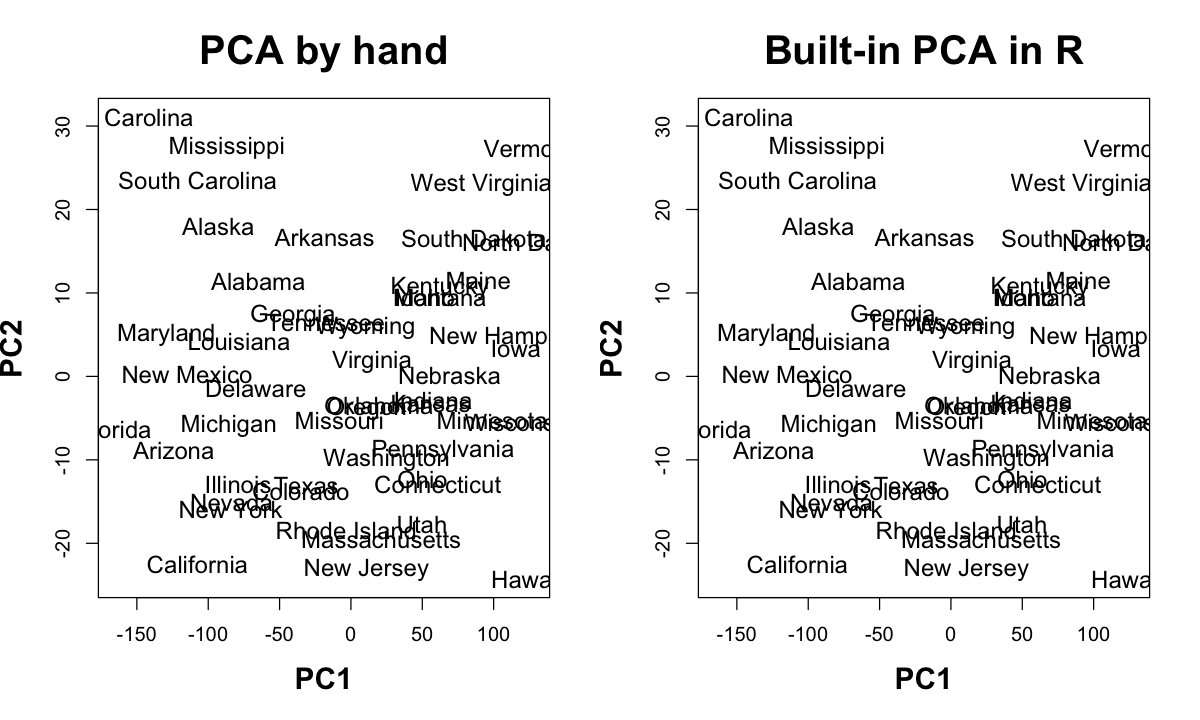

In [18]:
options(repr.plot.height=6 , repr.plot.width=10)
# PCA calculated by hand
par(mfrow=c(1,2),font.lab=2,cex.lab=1.5,cex.main=2)
#plot(dataInPC[,1:2],type='n',xlab='PC1',ylab='PC2',main='PCA by hand')
plot(dataInPC,type='n',xlab='PC1',ylab='PC2',main='PCA by hand')
text(dataInPC, labels=row.names(dataInPC), cex=1.2)

# PCA calculated by `printcomp` function
plot(pca$scores[,1:2],type='n',xlab='PC1',ylab='PC2',main='Built-in PCA in R')
text(pca$scores[,1:2], labels=row.names(USArrests), cex=1.2)

### Success!
The data look pretty much exactly the same. So there you have it. We explored some fundamentals of PCA and went through the process of reducing the dimensionality from 4 to 2. Maybe now you can cluster as well as a five-year old :)